# Modeling a strongly lensed source with `herculens`

In [1]:
%config InlineBackend.figure_format = 'retina' # higher resolution plots

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import os
from time import time
import numpy as np
from astropy.io import fits as pyfits
from copy import deepcopy
from pprint import pprint
%matplotlib inline


# Lenstronomy imports
from lenstronomy.Data.imaging_data import ImageData

# Herculens imports
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Analysis.plot import Plotter
from herculens.Util import util, image_util, param_util, plot_util

/Users/PierreBoccard/Documents/EPFL/summerstage/herculens/herculens/Analysis/plot.py:43: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix").copy()
  cmap_base.set_under('black')
/Users/PierreBoccard/Documents/EPFL/summerstage/herculens/herculens/Analysis/plot.py:44: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix").copy()
  cmap_base.set_over('white')


## Prepare data

### Load the image, exposure map and PSF kernel

In [2]:
#lentille_raw = "/home/astro/pboccard/summerstage/data/hst_wfpc2_J1206_drz.fits"
#lentille_raw = "data_pierre/hst_wfpc2_J1206_drz.fits"
lentille_raw = "/Users/PierreBoccard/Documents/EPFL/summerstage/pierre/hst_wfpc2_J1206_drz.fits"
data_lentillebis = pyfits.open(lentille_raw)
data_lentille = data_lentillebis[0].data[2020:2527,520:1027]

patch_bkg = data_lentillebis[0].data[2470:2620,220:370]
mediane = np.median(patch_bkg)
sigma_bkg = 1.48 * np.median(np.abs(patch_bkg - mediane))

data_lentille -= mediane

#exposition_raw = "/home/astro/pboccard/summerstage/data/hst_wfpc2_J1206_wht.fits"
#exposition_raw = "data_pierre/hst_wfpc2_J1206_wht.fits"
exposition_raw = "/Users/PierreBoccard/Documents/EPFL/summerstage/pierre/hst_wfpc2_J1206_wht.fits"
data_exposition = pyfits.open(exposition_raw)
data_exposition = data_exposition[0].data[2020:2527,520:1027]

delta = 26

#psf_raw = "/home/astro/pboccard/summerstage/data/tinytim_wfpc2_f606w_J1206.fits"
#psf_raw = "data_pierre/tinytim_wfpc2_f606w_J1206.fits"
psf_raw = "/Users/PierreBoccard/Documents/EPFL/summerstage/pierre/tinytim_wfpc2_f606w_J1206.fits"
data_psf = pyfits.open(psf_raw)
data_psf = data_psf[0].data[60 - delta : 61 + delta, 60 - delta : 61 + delta]

# header entries for the linear transformation (from a HST data header)
header = {'CD1_1': -1.3783350763348E-05,
            'CD1_2':  1.70894011082861E-06,
            'CD2_1': 1.70894011082861E-06,
            'CD2_2': 1.37833507633486E-05,
            'NAXIS1': 507,
            'NAXIS2': 507
            }

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header.get('CD1_1') * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header.get('CD1_2') * 3600
CD2_1 = header.get('CD2_1') * 3600
CD2_2 = header.get('CD2_2') * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# here we reduce the fov of view to speedup computations
reduce_fov = True

if reduce_fov is True:
    data_cut = 140
    data_lentille = data_lentille[data_cut:-data_cut, data_cut:-data_cut]
    data_exposition = data_exposition[data_cut:-data_cut, data_cut:-data_cut]

nx, ny = data_lentille.shape
x_c = int(nx / 2)
y_c = int(ny / 2)

reduce_psf = True
if reduce_psf is True:
    cut_psf = 10
    data_psf = data_psf[cut_psf:-cut_psf, cut_psf:-cut_psf]
    data_psf /= data_psf.sum()  # re-normalize psf

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

kwargs_data_original = {
    'image_data': data_lentille,
    'exposure_time': data_exposition,
    'background_rms': sigma_bkg,
    'ra_at_xy_0': ra_at_xy_0,
    'dec_at_xy_0': dec_at_xy_0,
    'transform_pix2angle': pix2coord_transform_undistorted,
}

# we create this class to convert lenstronomy's coordinates to herculens'
data_class_lenstronomy = ImageData(**kwargs_data_original)

### Substract lens light from the data

Here I assume that you have in hand all the parameters values in `kwargs_result`, including the amplitudes, are up to date.

In [3]:
kwargs_result = {'kwargs_lens': [{'theta_E': 2.550546049480918, 'gamma': 2.1999964931360365, 'e1': 0.23390735663133533, 'e2': -0.01748106629431686, 'center_x': 0.065, 'center_y': 0.07}, {'theta_E': 0.8451138583366518, 'e1': 0, 'e2': 0, 'center_x': -0.65, 'center_y': 1.289}, {'theta_E': 0.5148231132487855, 'e1': 0, 'e2': 0, 'center_x': 1.849, 'center_y': 0.333}, {'theta_E': 0.21450311818143594, 'center_x': -3.8, 'center_y': -1.41}, {'gamma1': 0.014590574612609502, 'gamma2': 0.06634097789046825, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 0.14051397827551404, 'R_sersic': 0.4999987125278008, 'n_sersic': 2.19999982534726, 'e1': -0.34496190690225736, 'e2': -0.06876516161622037, 'center_x': -0.5556774484124154, 'center_y': 0.6265115807969769}, {'amp': np.array([13.19222864,  4.32454281, -3.14385006,  6.08156958,  1.90763891,
        9.96802432, -1.65222791,  1.70816348,  2.51208226, -5.20135604,
       -0.07913599, -1.52909216,  5.20548699, -1.0801723 ,  7.51642085,
       -0.91510695,  2.79908044, -0.99844389,  2.85075088,  2.84342644,
       -1.95486883,  3.06239424, -0.89863084,  2.20433131, -0.0219856 ,
        4.17017008, -3.19506275,  3.31327476]), 'n_max': 6, 'beta': 0.05731838796168295, 'center_x': -0.5556774484124154, 'center_y': 0.6265115807969769}], 'kwargs_lens_light': [{'amp': 0.2052783175232013, 'R_sersic': 2.861261687478538, 'n_sersic': 3.9999983479501284, 'e1': 0.13116877071571234, 'e2': -0.01897676885165826, 'center_x': 0.065, 'center_y': 0.07}, {'amp': 14.199100031403404, 'R_sersic': 0.050000162968840904, 'n_sersic': 2.052441938576828, 'e1': -0.4999998075594972, 'e2': -0.15937776773618328, 'center_x': 0.065, 'center_y': 0.07}, {'amp': 0.4566127431242236, 'R_sersic': 0.40000118241020327, 'n_sersic': 3.9292955845590596, 'e1': 0, 'e2': 0, 'center_x': -0.65, 'center_y': 1.289}, {'amp': 6.639041766829386, 'R_sersic': 0.11950938134920452, 'n_sersic': 0.9456277644491751, 'e1': 0, 'e2': 0, 'center_x': 1.849, 'center_y': 0.333}, {'amp': 3.466673104325827, 'R_sersic': 0.08613217646908064, 'n_sersic': 3.982483204250846, 'center_x': -3.8, 'center_y': -1.41}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}

In [4]:
from lenstronomy.Util import class_creator

kwargs_model = {
    'lens_model_list': ['EPL', 'SIE', 'SIE', 'SIS', 'SHEAR'],
    'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC'],
    'source_light_model_list': ['SERSIC_ELLIPSE', 'SHAPELETS'],
}

multi_band_list = [[kwargs_data_original, {'psf_type': 'PIXEL', 'kernel_point_source': data_psf}, {'supersampling_factor': 1}]]

# here we generate the image model class
imSim = class_creator.create_im_sim(multi_band_list, 'single-band', kwargs_model, linear_solver=False)

# get the best.fit image of the lens light
lens_light_model = imSim.lens_surface_brightness(kwargs_lens_light=kwargs_result['kwargs_lens_light'])
lensed_source_model = imSim.source_surface_brightness(kwargs_result['kwargs_source'], kwargs_lens=kwargs_result['kwargs_lens'])
#lens_light_model = 0. # DELETE THIS


# subtract it from the data
data_lentille = data_lentille.astype(float)
data_no_lens_light = data_lentille - lens_light_model
data_no_source = data_lentille - lensed_source_model

## Prepare the model

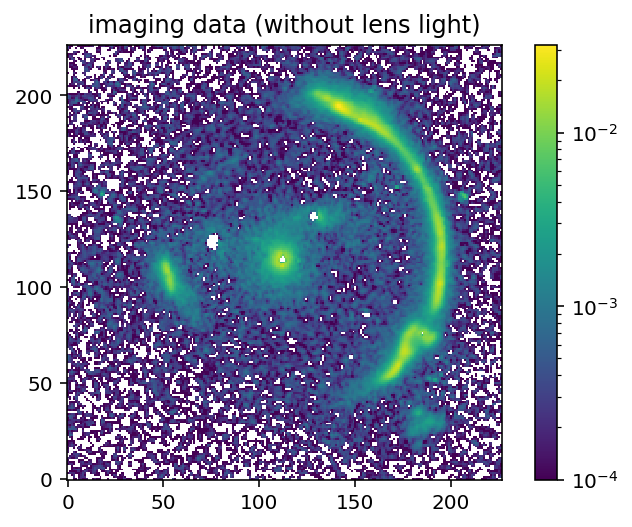

In [5]:
plt.title("imaging data (without lens light)")
plt.imshow(data_no_lens_light, origin='lower', norm=LogNorm(1e-4))
#plt.imshow(lensed_source_model, origin='lower', norm=LogNorm(1e-4))
plt.colorbar()
plt.show()

### Create arc mask

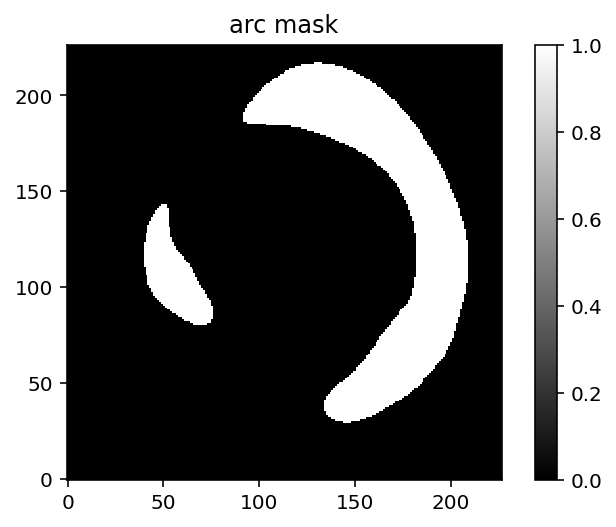

In [6]:
arc_mask = (lensed_source_model > 2e-4).astype(float)

plt.title("arc mask")
plt.imshow(arc_mask, origin='lower', cmap='gray')
plt.colorbar()
plt.show()

### Data coordinates grid

Currently, it is better to use `herculens` with coordinates aligned with the image axes, that is `transform_pix2angle` should be a diagonal matrix.

In [7]:
data = data_no_lens_light.astype(float)
exp_map = data_exposition.astype(float)

nx, ny = data_lentille.shape  # number of pixel on a side
pix_scl = data_class_lenstronomy.pixel_width  # pixel size in arcsec
transform_pix2angle = pix2coord_transform_undistorted


# create the PixelGrid class
pixel_grid = PixelGrid(nx, ny, transform_pix2angle=transform_pix2angle, 
                       ra_at_xy_0=ra_at_xy_0, dec_at_xy_0=dec_at_xy_0)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({nx}, {ny}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (227, 227) pixels
pixel size : 0.04999999999999894 arcsec
x range    : (4.911870253444888, -6.302263927615045) arcsec
y range    : (-6.3022639276152885, 4.911870253445131) arcsec


### Point spread function (PSF)

_Note: the PSF could be further reduced in size to accelerate the modeling (if so, do not forget to re-normalize the pixels!)._

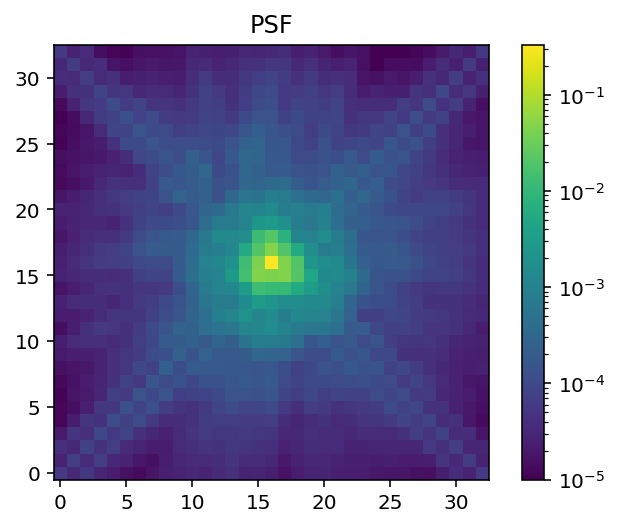

In [8]:
psf = PSF(psf_type='PIXEL', kernel_point_source=data_psf)

plt.title("PSF")
plt.imshow(psf.kernel_point_source, origin='lower', norm=LogNorm(1e-5))
plt.colorbar()
plt.show()

### Noise

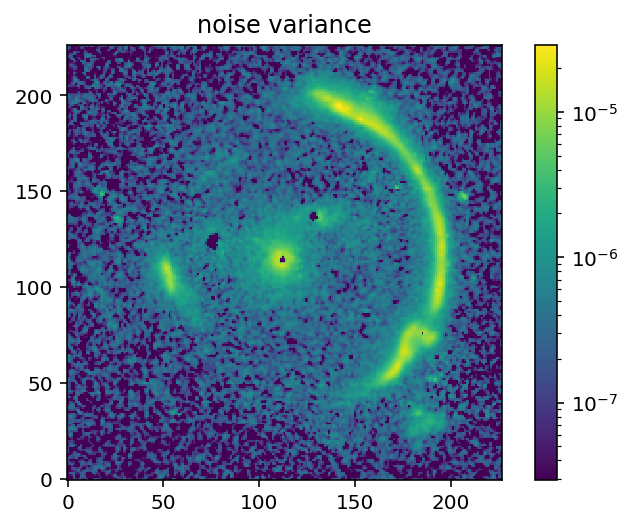

In [9]:
noise = Noise(nx, ny, background_rms=sigma_bkg, exposure_time=exp_map)
noise.set_data(data)

plt.title("noise variance")
plt.imshow(noise.C_D, origin='lower', norm=LogNorm())
plt.colorbar()
plt.show()

### Lens mass model

In [10]:
def convert_parameters(kwargs_result_in):
    kwargs_result_out = deepcopy(kwargs_result_in)
    
    for key, kwargs_list in kwargs_result_in.items():
        for i, kwargs in enumerate(kwargs_list):
            # makes sure 0s are float
            for name, value in kwargs.items():
                if isinstance(value, int) and value == 0:
                    kwargs_result_out[key][i][name] = float(value)
                
            # convert Sersic radius from product-average radius (lenstronomy) to major-axis (herculens)
            if 'R_sersic' in kwargs.keys():
                if 'e1' in kwargs.keys():
                    _, q = param_util.ellipticity2phi_q(kwargs_result_out[key][i]['e1'], kwargs_result_out[key][i]['e2'])
                else:
                    q = 1.
                R_sersic_in = kwargs_result_in[key][i]['R_sersic']
                R_sersic_out = R_sersic_in / np.sqrt(q)
                print("R_sersic before/after:", R_sersic_in, R_sersic_out)
                kwargs_result_out[key][i]['R_sersic'] = R_sersic_out
                
    # remove n_max because in Herculens it is given in LightModel
    n_max = kwargs_result_out['kwargs_source'][1].pop('n_max')
    # change amp to amps for shapelets
    kwargs_result_out['kwargs_source'][1]['amps'] = kwargs_result_out['kwargs_source'][1].pop('amp')
    # remove unused items
    del kwargs_result_out['kwargs_ps']
    del kwargs_result_out['kwargs_extinction']
    del kwargs_result_out['kwargs_special']
    
    return kwargs_result_out, n_max

In [11]:
kwargs_result_conv, shapelets_n_max = convert_parameters(kwargs_result)

R_sersic before/after: 0.4999987125278008 0.7220134676740656
R_sersic before/after: 2.861261687478538 3.2693178506377345
R_sersic before/after: 0.050000162968840904 0.08956363075539354
R_sersic before/after: 0.40000118241020327 0.4000577434610647
R_sersic before/after: 0.11950938134920452 0.11952628023974325
R_sersic before/after: 0.08613217646908064 0.08613217646908064


### Check if arc is correct in Herculens

In [12]:
# Choose the profiles
lens_mass_model_analytical = MassModel(kwargs_model['lens_model_list'])
lens_light_model_analytical = LightModel(kwargs_model['lens_light_model_list'])
source_model_analytical = LightModel(kwargs_model['source_light_model_list'],
                                     shapelets_n_max=shapelets_n_max)

In [13]:
kwargs_numerics_analytical = {'supersampling_factor': 1}
lens_image_analytical = LensImage(deepcopy(pixel_grid), psf, noise_class=noise,
                                  lens_mass_model_class=lens_mass_model_analytical,
                                  lens_light_model_class=lens_light_model_analytical,
                                  source_model_class=source_model_analytical,
                                  kwargs_numerics=kwargs_numerics_analytical)

In [14]:
kwargs_init_analytical = deepcopy(kwargs_result_conv)
kwargs_fixed = {
    'kwargs_lens': [{}, {}, {}, {}, {}],  # for a first model we fix all mass model parameters
    'kwargs_source': [{}, {}],
    'kwargs_lens_light': [{}, {}, {}, {}, {}],
}
parameters_analytical = Parameters(lens_image_analytical, kwargs_init_analytical, kwargs_fixed)

In [15]:
pprint(kwargs_result_conv)

{'kwargs_lens': [{'center_x': 0.065,
                  'center_y': 0.07,
                  'e1': 0.23390735663133533,
                  'e2': -0.01748106629431686,
                  'gamma': 2.1999964931360365,
                  'theta_E': 2.550546049480918},
                 {'center_x': -0.65,
                  'center_y': 1.289,
                  'e1': 0.0,
                  'e2': 0.0,
                  'theta_E': 0.8451138583366518},
                 {'center_x': 1.849,
                  'center_y': 0.333,
                  'e1': 0.0,
                  'e2': 0.0,
                  'theta_E': 0.5148231132487855},
                 {'center_x': -3.8,
                  'center_y': -1.41,
                  'theta_E': 0.21450311818143594},
                 {'dec_0': 0.0,
                  'gamma1': 0.014590574612609502,
                  'gamma2': 0.06634097789046825,
                  'ra_0': 0.0}],
 'kwargs_lens_light': [{'R_sersic': 3.2693178506377345,
                        'amp': 0

In [16]:
model_analytical = lens_image_analytical.model(**kwargs_result_conv)
lens_light_model_herculens = lens_image_analytical.lens_surface_brightness(kwargs_result_conv['kwargs_lens_light'])
lensed_source_model_herculens = lens_image_analytical.source_surface_brightness(kwargs_result_conv['kwargs_source'], 
                                                                                kwargs_lens=kwargs_result_conv['kwargs_lens'])


# only source sersic component
lensed_source_model_sersic = imSim.source_surface_brightness(kwargs_result['kwargs_source'], kwargs_lens=kwargs_result['kwargs_lens'], k=0)
lensed_source_model_herculens_sersic = lens_image_analytical.source_surface_brightness(kwargs_result_conv['kwargs_source'], 
                                                                                kwargs_lens=kwargs_result_conv['kwargs_lens'], k=0)
# un lensed
source_model_sersic = imSim.source_surface_brightness(kwargs_result['kwargs_source'], de_lensed=True, k=0)
source_model_herculens_sersic = lens_image_analytical.source_surface_brightness(kwargs_result_conv['kwargs_source'], de_lensed=True, k=0)

# convergence
xgrid_num_lenstro, ygrid_num_lenstro = imSim.ImageNumerics.coordinates_evaluate
xgrid_num_herculens, ygrid_num_herculens = lens_image_analytical.ImageNumerics.coordinates_evaluate
convergence = imSim.LensModel.kappa(xgrid_num_lenstro, ygrid_num_lenstro, kwargs_result['kwargs_lens'])
convergence = util.array2image(convergence)
convergence_herculens = lens_image_analytical.MassModel.kappa(xgrid_num_herculens, ygrid_num_herculens, kwargs_result_conv['kwargs_lens'])
convergence_herculens = util.array2image(convergence_herculens)


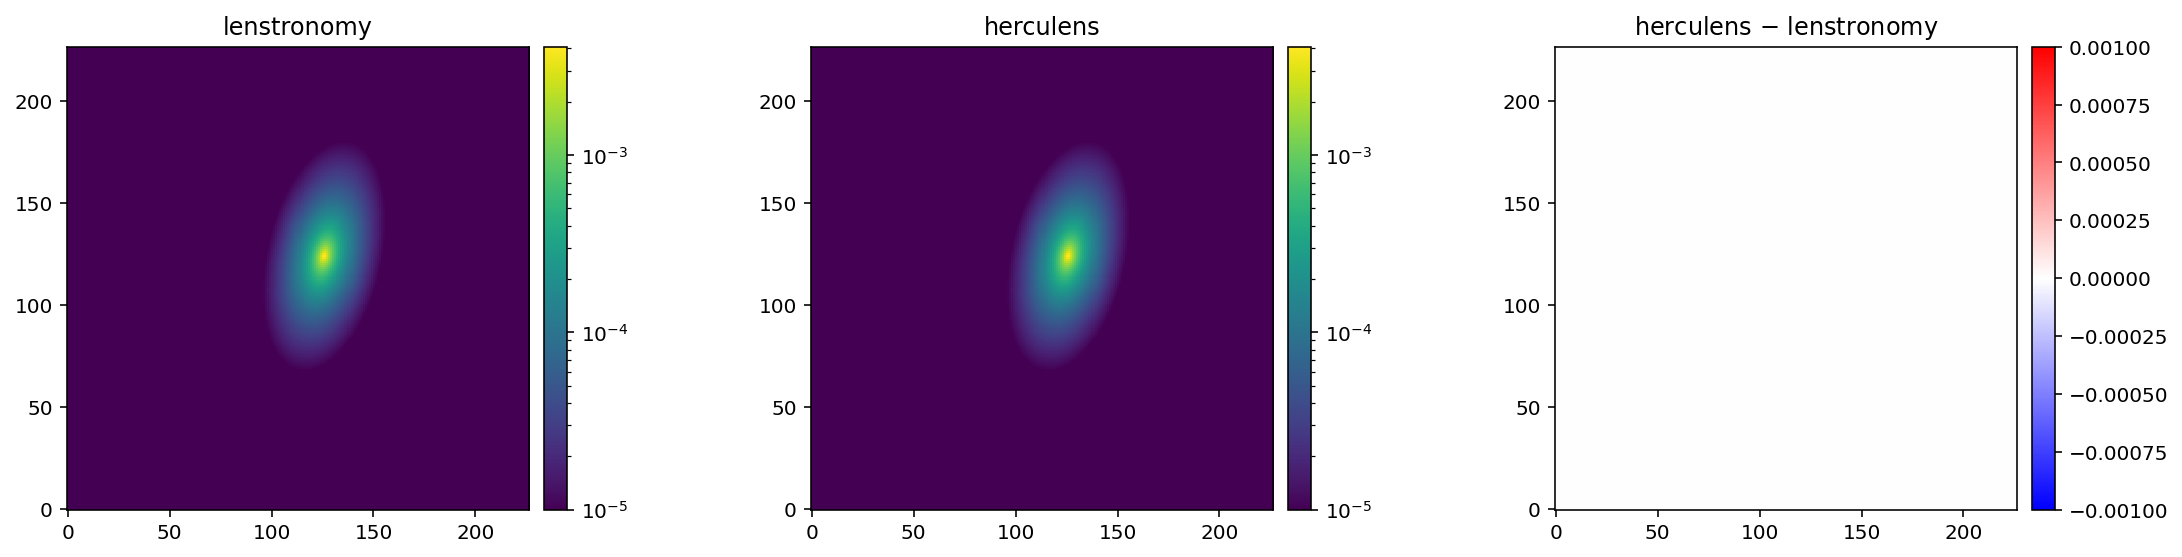

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
ax = axes[0]
ax.set_title("lenstronomy")
im = ax.imshow(source_model_sersic, origin='lower', norm=LogNorm(1e-5))
plot_util.nice_colorbar(im)

ax = axes[1]
ax.set_title("herculens")
im = ax.imshow(source_model_herculens_sersic, origin='lower', norm=LogNorm(1e-5))
plot_util.nice_colorbar(im)

ax = axes[2]
ax.set_title("herculens $-$ lenstronomy")
im = ax.imshow((source_model_herculens_sersic - source_model_sersic) / source_model_sersic, origin='lower', 
               norm=Normalize(-0.001, 0.001),
               #norm=TwoSlopeNorm(0),
               cmap='bwr')
plot_util.nice_colorbar(im)

plt.tight_layout()
plt.show()

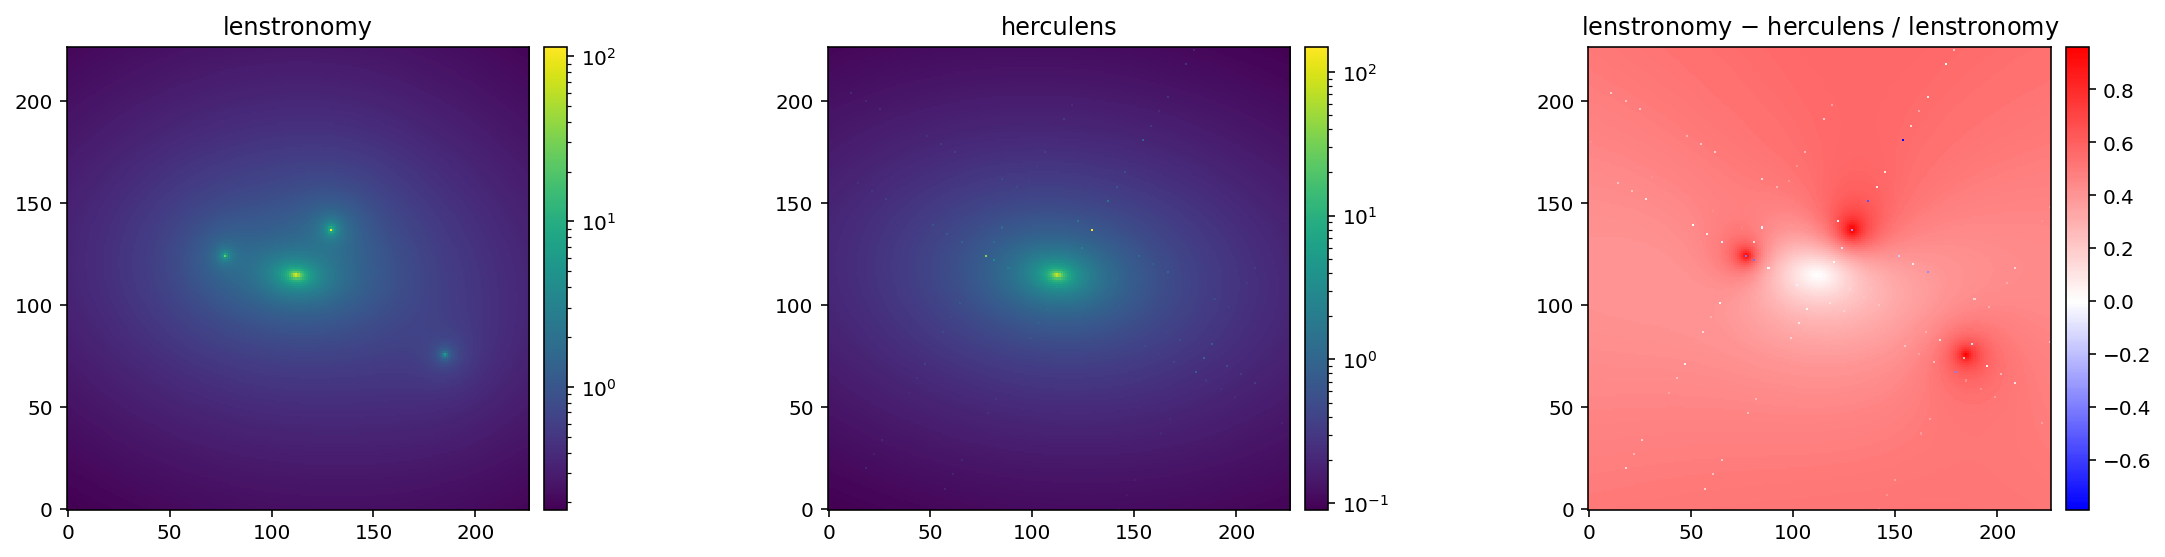

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
ax = axes[0]
ax.set_title("lenstronomy")
im = ax.imshow(convergence, origin='lower', norm=LogNorm())
plot_util.nice_colorbar(im)

ax = axes[1]
ax.set_title("herculens")
im = ax.imshow(convergence_herculens, origin='lower', norm=LogNorm())
plot_util.nice_colorbar(im)

ax = axes[2]
ax.set_title("lenstronomy $-$ herculens / lenstronomy")
im = ax.imshow((convergence - convergence_herculens) / convergence, origin='lower', 
               #norm=Normalize(-0.01, 0.01),
               norm=TwoSlopeNorm(0),
               cmap='bwr')
plot_util.nice_colorbar(im)

plt.tight_layout()
plt.show()

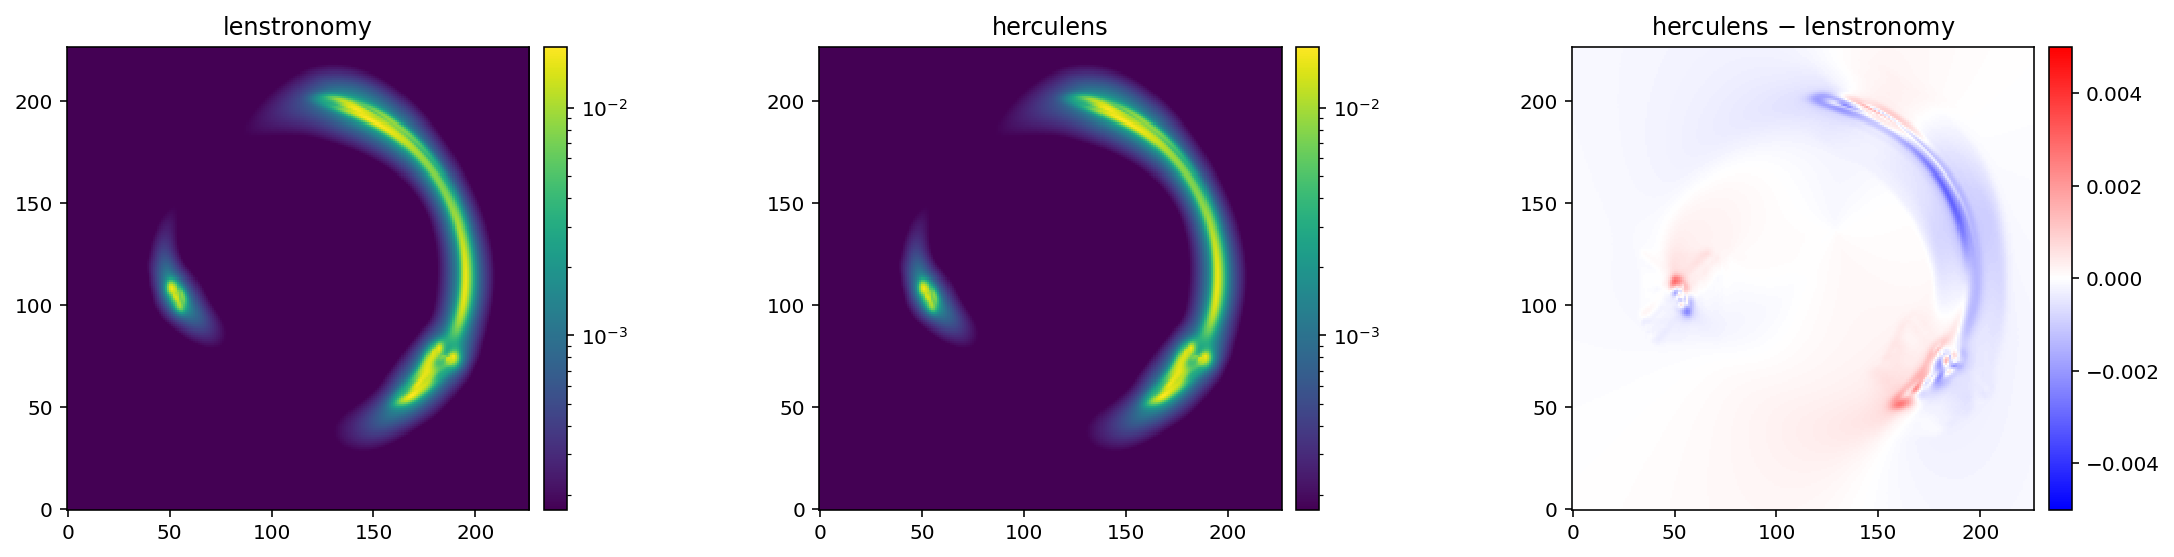

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
ax = axes[0]
ax.set_title("lenstronomy")
#im = ax.imshow(lensed_source_model_sersic, origin='lower', norm=LogNorm(1e-5))
im = ax.imshow(lensed_source_model, origin='lower', norm=LogNorm(sigma_bkg))
plot_util.nice_colorbar(im)

ax = axes[1]
ax.set_title("herculens")
#im = ax.imshow(lensed_source_model_herculens_sersic, origin='lower', norm=LogNorm(1e-5))
im = ax.imshow(lensed_source_model_herculens, origin='lower', norm=LogNorm(sigma_bkg))
plot_util.nice_colorbar(im)

ax = axes[2]
ax.set_title("herculens $-$ lenstronomy")
#im = ax.imshow((lensed_source_model_herculens_sersic - lensed_source_model_sersic) / lensed_source_model_sersic, origin='lower', cmap='bwr')
im = ax.imshow((lensed_source_model_herculens - lensed_source_model) / lensed_source_model, origin='lower', 
               norm=Normalize(-0.005, 0.005),
               #norm=TwoSlopeNorm(0),
               cmap='bwr')
plot_util.nice_colorbar(im)

plt.tight_layout()
plt.show()

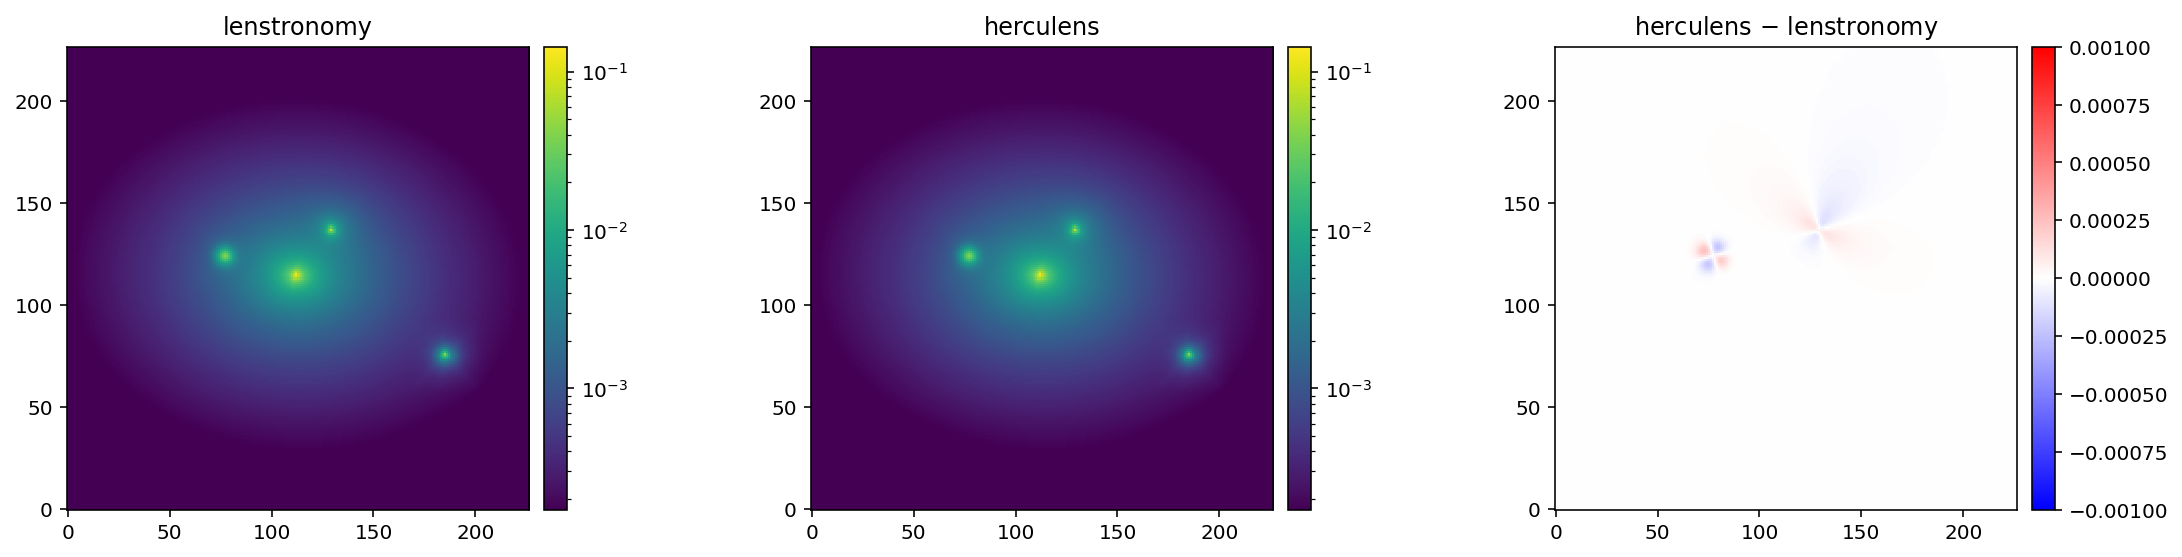

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
ax = axes[0]
ax.set_title("lenstronomy")
im = ax.imshow(lens_light_model, origin='lower', norm=LogNorm(sigma_bkg))
plot_util.nice_colorbar(im)

ax = axes[1]
ax.set_title("herculens")
im = ax.imshow(lens_light_model_herculens, origin='lower', norm=LogNorm(sigma_bkg))
plot_util.nice_colorbar(im)

ax = axes[2]
ax.set_title("herculens $-$ lenstronomy")
im = ax.imshow((lens_light_model_herculens - lens_light_model) / lens_light_model, origin='lower', 
               norm=Normalize(-0.001, 0.001),
               #norm=TwoSlopeNorm(0),
               cmap='bwr')
plot_util.nice_colorbar(im)

plt.tight_layout()
plt.show()

## Pixelated source reconstruction

### Create a model for fitting

In [21]:
# Setup the mass model
lens_mass_model = MassModel(kwargs_model['lens_model_list'])

# Setup the source model:
# - choose the source pixel scale factor = data pixel size / source pixel size
# - choose the grid center: INSERT SERSIC CENTER VALUES
# - choose the shape of the grid, i.e. the size of the source plane in arcsec in each direction
src_ctr_x = kwargs_result_conv['kwargs_source'][0]['center_x']
src_ctr_y = kwargs_result_conv['kwargs_source'][0]['center_y']
src_size = 2*kwargs_result_conv['kwargs_source'][0]['R_sersic']
kwargs_pixelated_source = {
    'pixel_scale_factor': 1/3.,
    'grid_center': (src_ctr_x, src_ctr_y), 
    'grid_shape': (src_size, src_size), # arcsec
}
pprint(kwargs_pixelated_source)
source_model = LightModel(['PIXELATED'],
                          kwargs_pixelated=kwargs_pixelated_source)

kwargs_numerics_fit = {'supersampling_factor': 1}
lens_image = LensImage(deepcopy(pixel_grid), psf, noise_class=noise,
                       lens_mass_model_class=lens_mass_model,
                       source_model_class=source_model,
                       kwargs_numerics=kwargs_numerics_fit,
                       recompute_model_grids=True)

{'grid_center': (-0.5556774484124154, 0.6265115807969769),
 'grid_shape': (1.4440269353481312, 1.4440269353481312),
 'pixel_scale_factor': 0.3333333333333333}


In [22]:
kwargs_lens_init = deepcopy(kwargs_result_conv['kwargs_lens']) # deepcopy to make sure the initial values are not overwritten

kwargs_init = {
    'kwargs_lens': kwargs_lens_init, 
    'kwargs_source': [{'pixels': 1e-8}],  # uniform initial value for all pixels
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': kwargs_lens_init,  # for a first model we fix all mass model parameters
    'kwargs_lens_light': [{}],
    'kwargs_source': [{}],
}
parameters = Parameters(lens_image, kwargs_init, kwargs_fixed)
print("Number of fitted parameters:", parameters.num_parameters)
#print("Parameter names:", parameters.names)

Number of fitted parameters: 7569


### Define the loss function

For now, `herculens` supports only a simple euclidean distance as the likelihood term (`'l2_norm'`), instead than the more usual $\chi^2$ (`'chi2'`). This will be soon implemented.

In [23]:
loss = Loss(data, lens_image, parameters, 
            likelihood_type='l2_norm',
            likelihood_mask=arc_mask,
            regularization_terms=['l1_starlet_source', 
                                  'l1_battle_source', 
                                  'positivity_source'], 
            regularization_strengths=[(0.1, 0.1), 0.1, 0.1])

print("Loss at initial values:", loss(parameters.initial_values()))

Loss at initial values: 0.079689816


### Minimise the loss function using `optax`

We use the adaptive gradient descent algorithm AdaBelief to optimize the values of all source pixels.

In [24]:
optimizer = Optimizer(loss, parameters)

# optimizer settings: tweak these to obtain good convergence in the next plot
max_iterations = 1000
init_learning_rate = 9e-6

best_fit, logL, extra_fields, runtime \
    = optimizer.optax(max_iterations=max_iterations, 
                      init_learning_rate=init_learning_rate,
                      restart_from_init=True)
print(f"Runtime: {runtime}") 
print("Loss at best-fit:", loss(best_fit))

optax.adabelief: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [20:39<00:00,  1.24s/it]


Runtime: 1239.6350429058075
Loss at best-fit: 0.0034450279


In [25]:
# save results as kwargs
kwargs_final = parameters.best_fit_values(as_kwargs=True)

#file = open(f"kwargs_final.txt", "w+")
#result = str(kwargs_final)
#file.write(result)
#file.close()

import pickle

with open('kwargs_final18.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(kwargs_final, file)

In [26]:
print(kwargs_final['kwargs_source'])

[{'pixels': DeviceArray([[3.3032894e-04, 3.2571674e-04, 3.2513513e-04, ...,
              2.0078136e-04, 1.7599254e-04, 1.4391050e-04],
             [3.2995813e-04, 3.2931563e-04, 3.2817753e-04, ...,
              2.0811733e-04, 1.9159472e-04, 1.8239515e-04],
             [3.3489743e-04, 3.3272165e-04, 3.3125581e-04, ...,
              2.1561244e-04, 2.0750184e-04, 2.0158129e-04],
             ...,
             [8.0161844e-05, 7.4932112e-05, 6.7143978e-05, ...,
              2.5385915e-04, 2.4562830e-04, 2.4195472e-04],
             [9.7776181e-05, 8.2608742e-05, 5.8990550e-05, ...,
              2.5495104e-04, 2.4481094e-04, 2.3716067e-04],
             [1.3527107e-04, 8.6441250e-05, 5.3510383e-05, ...,
              2.5581257e-04, 2.4331751e-04, 2.3512580e-04]],            dtype=float32)}]


/Users/PierreBoccard/Documents/EPFL/summerstage/herculens/herculens/Util/plot_util.py:34: UserWarning: No `'param_history'` found in the extra fields (use `return_param_history=True` in Optimizer).
  warnings.warn("No `'param_history'` found in the extra fields (use `return_param_history=True` in Optimizer).")


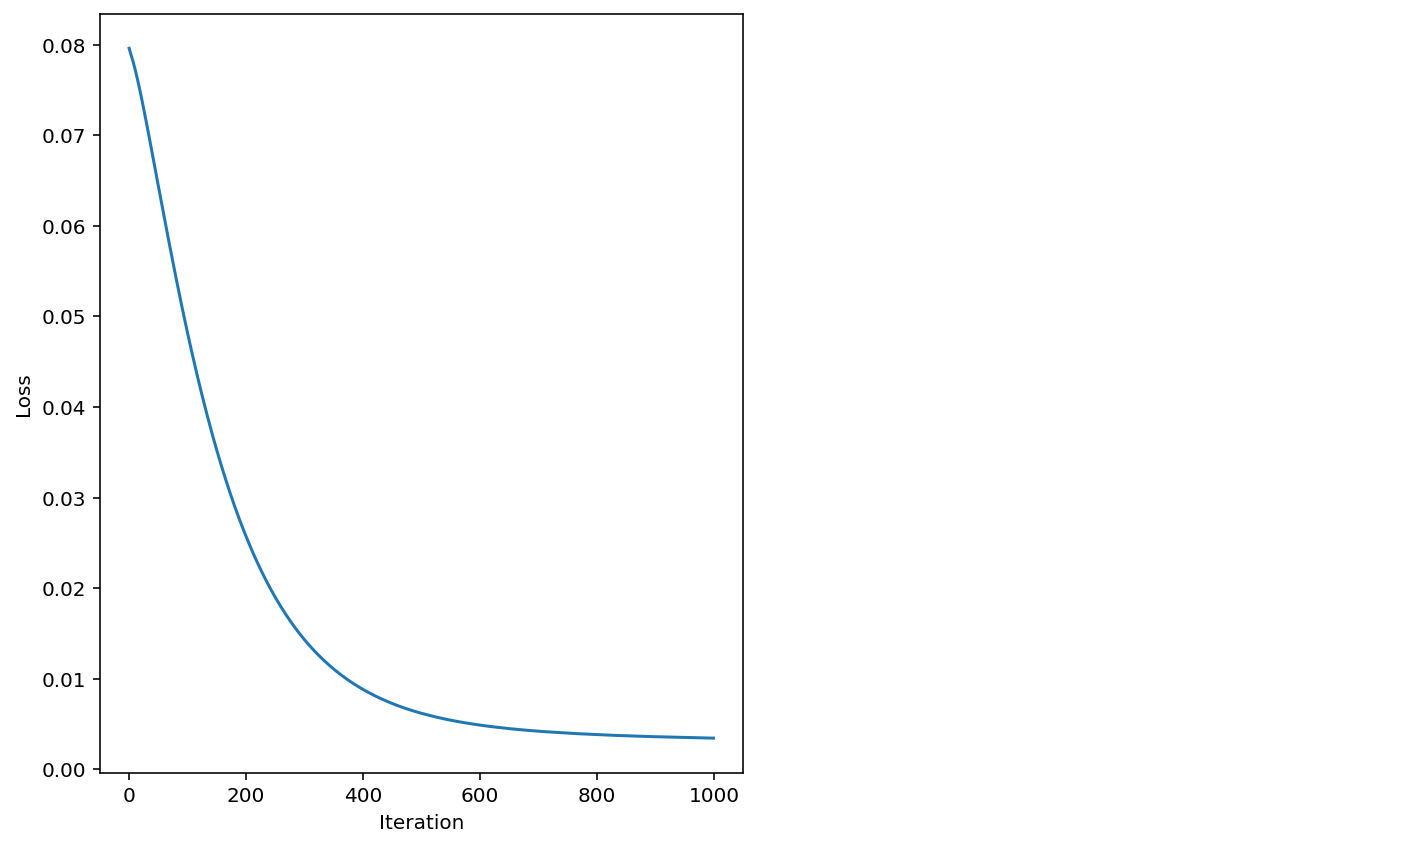

In [27]:
plot_util.plot_minimize_history(parameters, extra_fields)

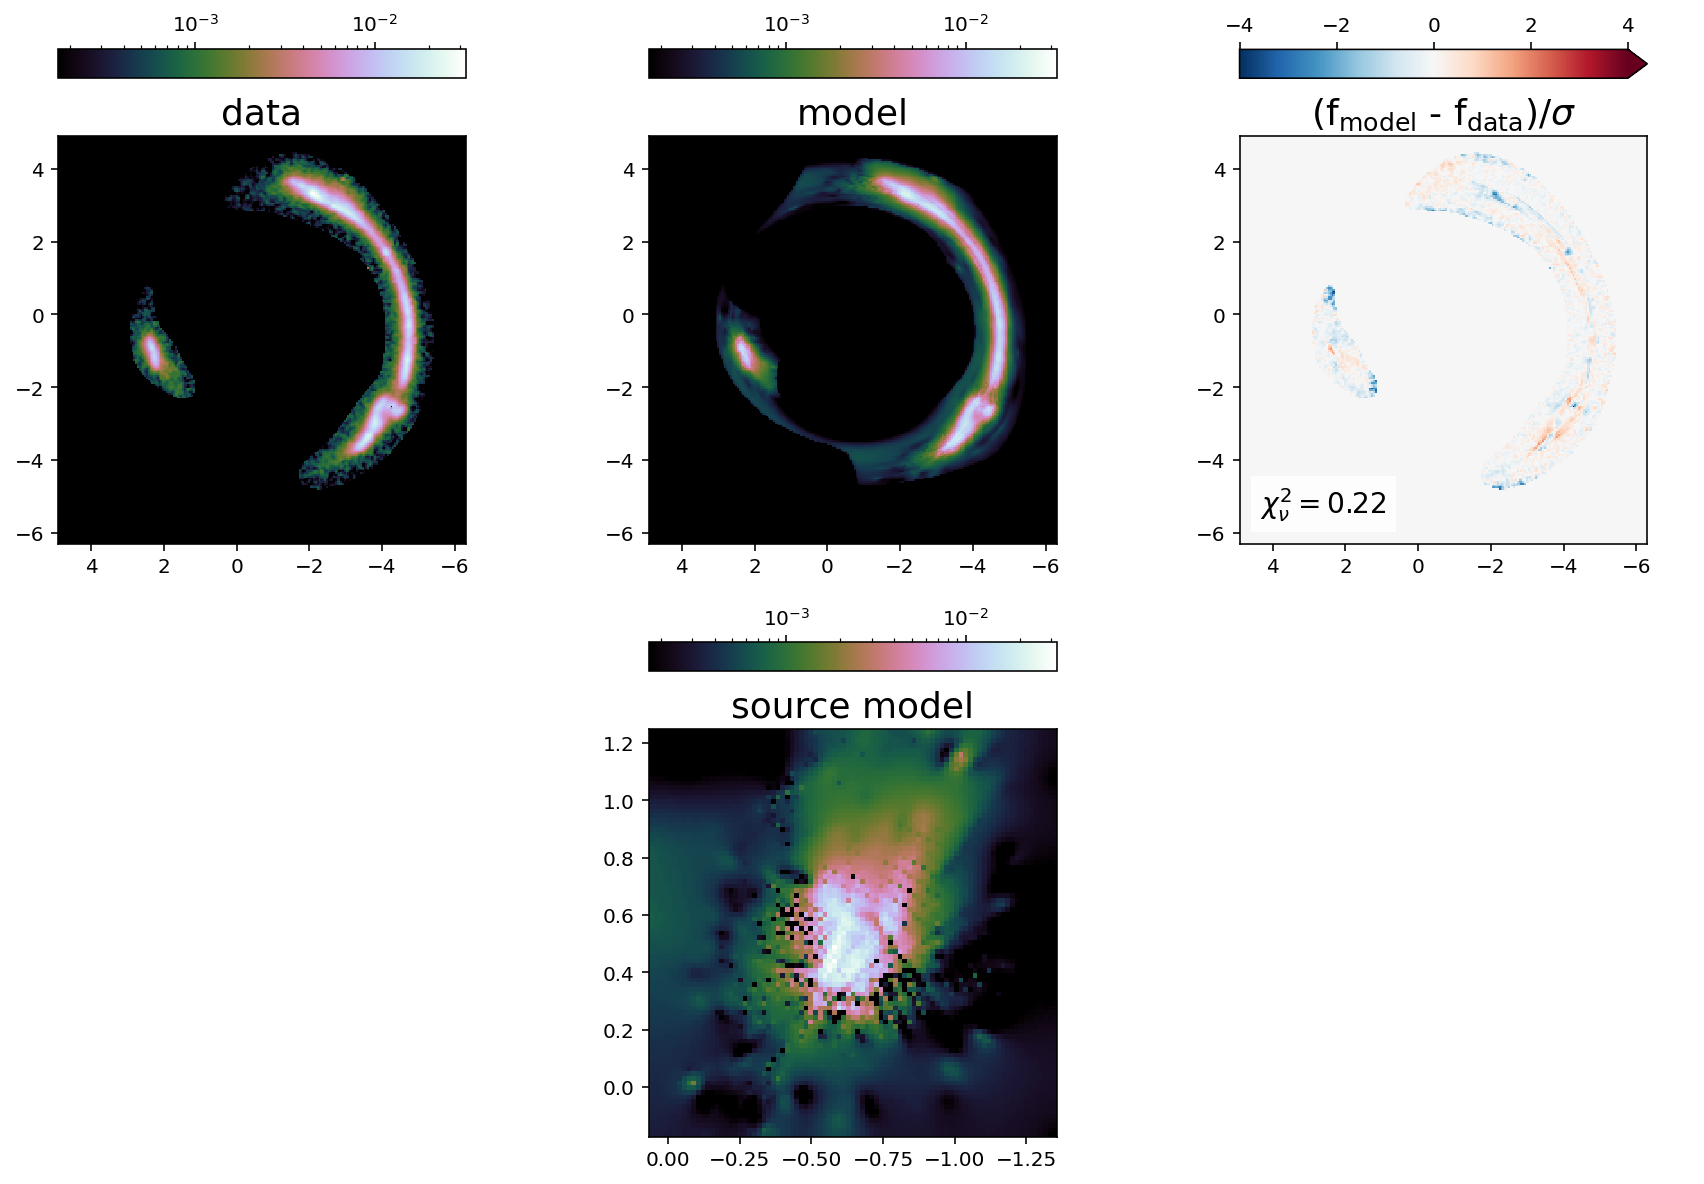

In [28]:
# Plotting engine
plotter = Plotter(base_fontsize=18, flux_vmin=sigma_bkg, res_vmax=4)
plotter.set_data(data)

fig = plotter.model_summary(lens_image, kwargs_final, likelihood_mask=arc_mask)
fig.savefig('test18.jpg', dpi=150)
plt.show()
